# Linear regression with Laplace approximation

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

from gaul import quap

import matplotlib.pyplot as plt
import seaborn as sns
import corner

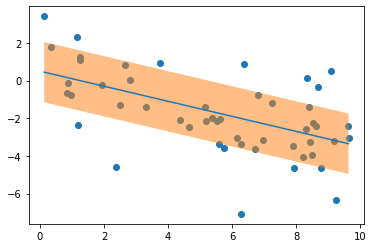

In [2]:
beta0 = 0.5
beta1 = -0.4
sigma = 1.6
n = 50

key = jax.random.PRNGKey(0)
xkey, ykey = jax.random.split(key)

x = jax.random.uniform(xkey, shape=(n,)) * 10.
x = jnp.sort(x)
ymean = beta0 + beta1 * x
y = jax.random.normal(ykey, shape=(n,)) * sigma + ymean

plt.scatter(x, y)
plt.plot(x, ymean)
plt.fill_between(x, ymean - sigma, ymean + sigma, alpha=0.5)

In [3]:
def ln_posterior(params, data):
    target = 0
    
    target += stats.norm.logpdf(params['beta0'], 0., 2.)
    target += stats.norm.logpdf(params['beta1'], 0., 2.)
    target += stats.expon.logpdf(jnp.exp(params['sigma']), scale=1.)
    
    ymean = params['beta0'] + params['beta1'] * data['x']
    target += stats.norm.logpdf(data['y'], ymean, jnp.exp(params['sigma'])).sum()
    
    return target.sum()

In [4]:
params = dict(
    beta0=jnp.zeros(1),
    beta1=jnp.zeros(1),
    sigma=jnp.ones(1),
)

data = dict(
    x=x,
    y=y,
)

In [8]:
samples = quap.sample(
    ln_posterior,
    params,
    nsteps=10000,
    nsamples=5000,
    data=data
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
samples = jax.tree_util.tree_map(lambda x: x.reshape(-1), samples)

<AxesSubplot:ylabel='Density'>

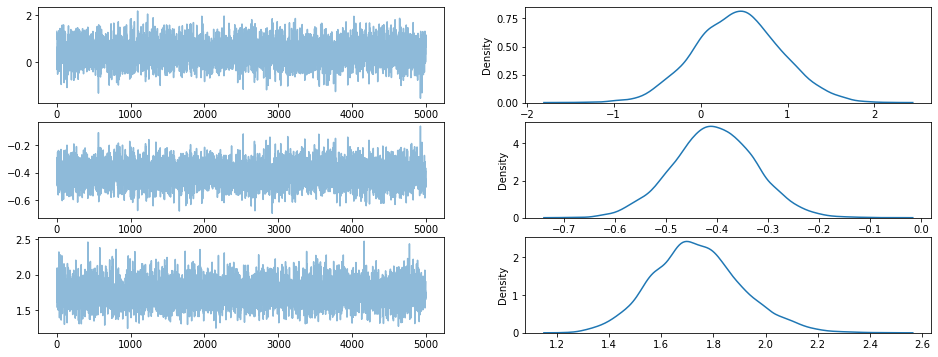

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(16, 6))

ax[0,0].plot(samples['beta0'], alpha=0.5)
ax[1,0].plot(samples['beta1'], alpha=0.5)
ax[2,0].plot(jnp.exp(samples['sigma']), alpha=0.5)

sns.kdeplot(samples['beta0'], ax=ax[0,1])
sns.kdeplot(samples['beta1'], ax=ax[1,1])
sns.kdeplot(jnp.exp(samples['sigma']), ax=ax[2,1])

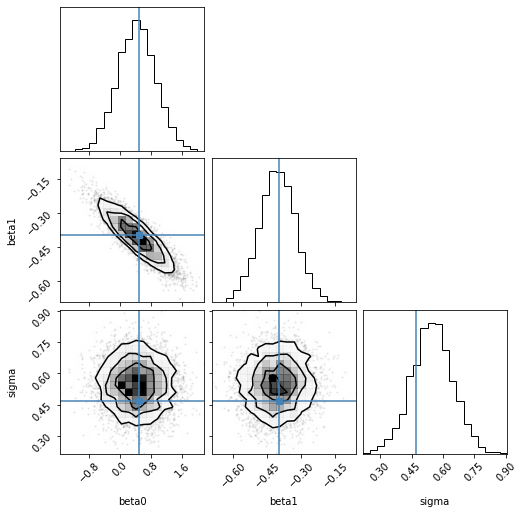

In [8]:
corner.corner(samples, truths=[beta0, beta1, jnp.log(sigma)]);

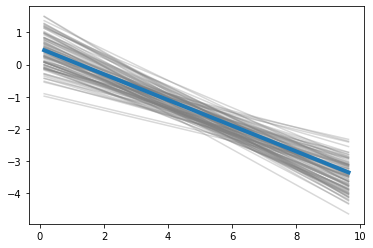

In [19]:
def sim_linreg(beta0, beta1, sigma, rng):
    ymean_sim = beta0 + beta1 * x
    return ymean_sim

y_sim = jax.vmap(sim_linreg)(
    samples['beta0'],
    samples['beta1'],
    samples['sigma'],
    jax.random.split(ykey, 5000)
)

for i in range(100):
    plt.plot(x, y_sim[i], c='grey', alpha=0.3)
plt.plot(x, ymean, lw=4)